In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter, OrderedDict
import Bio.PDB.Polypeptide as pp
from os.path import join
import os

In [2]:
AA = list(pp.aa1)

In [3]:
DATA = 'data/'

In [138]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

### Functional Data

In [4]:
proteins = ['1be9', '1d5r', '1nd4', '3dqw', '4bz3']
protein_names = ['PSD95', 'PTEN', 'APH(3\')II', 'Src CD', 'VIM-2']

In [5]:
functional_data = dict()
for protein in proteins:
    csv_file = join(DATA, f'functional_{protein}.csv')
    functional_data[protein] = pd.read_csv(csv_file, index_col=0, header=0)

### Perturbation Network Data and Related Functions

In [6]:
data_path = join(DATA, 'structure')
thresholds = [round(i, 1) for i in np.linspace(3, 10, 71)]
sample_thresholds = [round(i, 1) for i in np.linspace(3, 10, 8)]
measures = ['nodes', 'edges', 'weight', 'distance']

In [7]:
tex_fonts = {
    # Use LaTeX to write all text
    "text.usetex": True,
    "font.family": "serif",
    # Use 10pt font in plots, to match 10pt font in document
    "axes.labelsize": 10,
    "font.size": 10,
    # Make the legend/label fonts a little smaller
    "legend.fontsize": 8,
    "xtick.labelsize": 8,
    "ytick.labelsize": 8
}

plt.rcParams.update(tex_fonts)

In [8]:
def set_size(width, fraction=1):
    """Set figure dimensions to avoid scaling in LaTeX.

    Parameters
    ----------
    width: float
            Document textwidth or columnwidth in pts
    fraction: float, optional
            Fraction of the width which you wish the figure to occupy

    Returns
    -------
    fig_dim: tuple
            Dimensions of figure in inches
    """
    # Width of figure (in pts)
    fig_width_pt = width * fraction

    # Convert from pt to inches
    inches_per_pt = 1 / 72.27

    # Golden ratio to set aesthetic figure height
    # https://disq.us/p/2940ij3
    golden_ratio = (5**.5 - 1) / 2

    # Figure width in inches
    fig_width_in = fig_width_pt * inches_per_pt
    # Figure height in inches
    fig_height_in = fig_width_in * golden_ratio

    fig_dim = (fig_width_in, fig_height_in)

    return fig_dim

In [9]:
def ReadNetworkCSV(protein, threshold, measure):
    """Return DataFrame from corresponding CSV. If protein has multiple identical chains, return average value for 
    each position amongst all chains."""
    file = os.path.join(join(DATA, 'structure'), f"{protein}/{protein}_{threshold}_{measure}.csv")
    network_df = pd.read_csv(file, header=0)
    network_df.index = AA
    # Get chains from columns
    column_names = list(network_df.columns)
    chains = list(set([position[1] for position in column_names]))
    # Get positions without chain distinction from functional files
    positions = list(functional_data[protein].columns)
    average = pd.DataFrame(index=AA, columns=positions, dtype=np.float64)
    # Save data for position over chains in list, write average into df
    for position in positions:
        for aa in AA:
            values = []
            for chain in chains:
                check = position[0]+chain+position[1:]
                if check in network_df.columns:
                    values.append(network_df.at[aa, check])
            if values:
                average_value = sum(values)/len(values)
                average.at[aa, position] = average_value
    return average

In [10]:
def Standardize(protein, threshold, measure):
    """Return standardized values from network data. Make 0's into NaN. """
    network_df = ReadNetworkCSV(protein, threshold, measure)
    for position in network_df.columns:
        for aa in network_df.index:
            if position[0] == aa:
                network_df.at[aa, position] = np.nan
    data_array = network_df.to_numpy()
    data_mean = np.nanmean(network_df, dtype=np.float64)
    data_std = np.nanstd(network_df, dtype=np.float64)
    network_df = network_df.apply(lambda x:(x-data_mean)/data_std)
    return network_df 

In [11]:
def GetPercentage(percentage, which, data, return_score=False):
    """Return set with top or bottom percentage of positions according to functional data. 
    Parameters:
        percentage (float): between 0 and 1, percentage of positions that we want.
        which (str): 'highest', 'lowest'
        data (dataframe): functional data to consider mean of
        return_score (bool): If True, return list of tuples with mean value and position
    Returns:
        Set of positions.
    """
    functional_mean = data.mean()
    positions = list(data.columns)
    pairs = [(functional_mean[pos], pos) for pos in positions] 
    pairs.sort(key = lambda x:x[0]) 
    if which == 'highest': 
        pairs.reverse() 
    n = int(len(positions)*percentage)
    if return_score:
        return [pair for pair in pairs[:n]]
    else:
        return set([pair[1] for pair in pairs[:n]])

In [12]:
def GetNetworkExtremes(protein, mincount, measure_cutoffs, thresh=9.0):
    """ Return set with positions that pass measure sd cutoffs for at least mincount measures. """
    network_extremes_list = []
    for i,measure in enumerate(measures): 
        threshold = 3.8 if measure == 'distance' else thresh
        network_df = Standardize(protein, threshold, measure)
        if measure_cutoffs[i] > 0:
            extremes = network_df.columns[(network_df > measure_cutoffs[i]).any()].tolist()
        else:
            extremes = network_df.columns[(network_df < measure_cutoffs[i]).any()].tolist()
        network_extremes_list.extend(extremes)

    counter = Counter(network_extremes_list)
    positions = list(set(network_extremes_list))
    return set([pos for pos in positions if counter[pos] >= mincount])

In [13]:
def ToPercentage(a,b):
    """Return percentage form of a/b, if b != 0. If given set or list, use len of. 
    If string, return formatted percentage, else float."""
    x = a if type(a) == int or type(a) == float else len(a)
    y = b if type(b) == int or type(b) == float else len(b)
    
    if y == 0:
        return np.nan
    else:
        return round(100*x/y,1)

### Accuracy and Coverage vs Position Percentages

Compare Accuracy scores with functional percentage, leaving parameters fixed at [1,1,1,1] and mincount of 2; 
    and Coverage scores with prediction percentage, leaving functional percentage fixed at 40%, mincount fixed at 2,
    and varying the functional cutoffs from 1 to 2. Considering loss of function predictions. 

In [179]:
# list to save data, values will be (percentage, score, type, protein)
data_ac = []

In [180]:
# Accuracy and functional percentage
percentage_range = [round(i,2) for i in np.linspace(0.3, 0.7, 41)] # diff funct percentages to test
for i, protein in enumerate(proteins):
    network_extremes = GetNetworkExtremes(protein, 2, measure_cutoffs=[1,1,1,1])
    for percentage in percentage_range:
        funct_extremes = GetPercentage(percentage, 'lowest', functional_data[protein])
        how_many = funct_extremes.intersection(network_extremes)
        score = ToPercentage(how_many, network_extremes)
        data_ac.append((round(percentage*100,0), score, "Accuracy - FSP", protein_names[i]))

In [181]:
# Coverage and functional percentage
for i, protein in enumerate(proteins):
    coverage = []
    network_extremes = GetNetworkExtremes(protein, 2, measure_cutoffs=[1,1,1,1])
    for percentage in percentage_range:
        funct_extremes = GetPercentage(percentage, 'lowest', functional_data[protein])
        how_many = funct_extremes.intersection(network_extremes)
        score = ToPercentage(how_many, funct_extremes)
        data_ac.append((round(percentage*100,0), score, "Coverage - FSP", protein_names[i]))

In [182]:
# Accuracy and coverage prediction percentage    
cutoffs = [round(i,2) for i in np.linspace(1,2,81)] # cutoffs to use to get diff prediction percentages
for i, protein in enumerate(proteins):
    coverage, accuracy = [], []
    percentages_added = [] # Keep track of percentages to avoid repeats with different scores when rounding
    n = len(functional_data[protein].columns)
    prediction_percentage = []
    funct_extremes = GetPercentage(0.4, 'lowest', functional_data[protein])
    for cutoff in cutoffs:
        network_extremes = GetNetworkExtremes(protein, 2, measure_cutoffs=[cutoff]*4)
        how_many = funct_extremes.intersection(network_extremes)
        percentage = round(ToPercentage(network_extremes, n), 0)
        score_acc = ToPercentage(how_many, network_extremes)
        score_cov = ToPercentage(how_many, funct_extremes)
        if percentage not in percentages_added:
            data_ac.append((percentage, score_acc, "Accuracy - Prediction Percentage", protein_names[i]))
            data_ac.append((percentage, score_cov, "Coverage - Prediction Percentage", protein_names[i]))
            percentages_added.append(percentage)

In [183]:
data_ac = pd.Series(data_ac).drop_duplicates().tolist()

In [184]:
df2 = pd.DataFrame(data_ac, columns=['Percentage', 'Score', 'Type', 'Protein'])

In [185]:
for protein in protein_names:
    pers = df2.loc[(df2['Type']=='Accuracy - Prediction Percentage') & (df2['Protein']==protein), 
                       'Percentage'].tolist()
    scores = df2.loc[(df2['Type']=='Accuracy - Prediction Percentage') & (df2['Protein']==protein), 'Score'].tolist()
    pairs = [i for i in zip(pers, scores)]
    pairs.sort()
    pairs = np.array(pairs)
    per_range = np.arange(pairs[0][0], pairs[-1][0])
    # Fill in missing values with linear interpolation
    lin_interp = np.interp(per_range, pairs[:,0], pairs[:,1])
    # Add missing values to dataframe
    for i, percentage in enumerate(per_range):
        if percentage not in pairs:
            df2.loc[len(df2)] = [percentage, lin_interp[i], 'Accuracy - Prediction Percentage', protein]

In [186]:
for protein in protein_names:
    pers = df2.loc[(df2['Type']=='Coverage - Prediction Percentage') & (df2['Protein']==protein), 
                       'Percentage'].tolist()
    scores = df2.loc[(df2['Type']=='Coverage - Prediction Percentage') & (df2['Protein']==protein), 'Score'].tolist()
    pairs = [i for i in zip(pers, scores)]
    pairs.sort()
    pairs = np.array(pairs)
    per_range = np.arange(pairs[0][0], pairs[-1][0])
    # Fill in missing values with linear interpolation
    lin_interp = np.interp(per_range, pairs[:,0], pairs[:,1])
    # Add missing values to dataframe
    for i, percentage in enumerate(per_range):
        if percentage not in pairs:
            df2.loc[len(df2)] = [percentage, lin_interp[i], 'Coverage - Prediction Percentage', protein]

In [215]:
?sns.FacetGrid

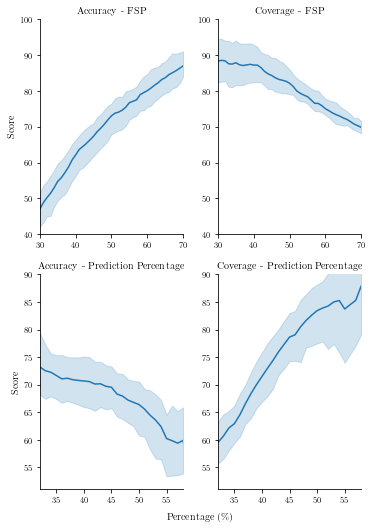

In [229]:
g2 = sns.FacetGrid(data=df2, col="Type", sharex=False, sharey=False, col_wrap=2, height=4, aspect=0.66)
g2.map(sns.lineplot, "Percentage", "Score")
g2.set_titles(row_template = '{row_name}', col_template = '{col_name}')
g2.set_axis_labels("", "Score")
g2.fig.text(0.45,0.04, "Percentage (\%)")

for i, ax in enumerate(g2.axes.flat):
    ax.set_aspect(1)
    if i in [0,1]:
        ax.set_xlim(30,70)
        ax.set_ylim(40,100)
    else:
        ax.set_xlim(32,58)
        ax.set_ylim(51,90)
        ax.set_xticks([35, 40, 45, 50, 55])

plt.subplots_adjust(hspace=-0.2)
plt.tight_layout()
    
g2.savefig('figures/behavior2.png', dpi=300)

### Predictions for single measure

In [104]:
def NetworkExtremesOneMeasure(protein, measure, cutoff, threshold):
    """ Return set with positions that have mutations that pass measure cutoff. """
    network_df = Standardize(protein, threshold, measure)
    extremes = network_df.columns[(network_df > cutoff).any()].tolist()
    return set(extremes)

In [106]:
def dataOneMeasure(cutoff):
    """Loss of function predictions based only on one measure. """
    index = pd.MultiIndex.from_product([proteins, measures, ["Accuracy", "Coverage"]], 
                                       names=["Protein", "Measure", "Score"])
    df = pd.DataFrame(index=index, columns=thresholds)
    
    for j, measure in enumerate(measures):
        for i, protein in enumerate(proteins):
            funct_extremes = GetPercentage(0.4, 'lowest', functional_data[protein])
            
            for threshold in thresholds:
                # positions predicted
                predictions = NetworkExtremesOneMeasure(protein, measure, cutoff, threshold)
                # positions in intersection between predictions and funct_extremes 
                how_many = predictions.intersection(funct_extremes)
                df.at[(protein, measure, "Accuracy"), threshold] = ToPercentage(how_many, predictions)
                df.at[(protein, measure, "Coverage"), threshold] = ToPercentage(how_many, funct_extremes)
    return df

In [111]:
def PredictionsOneMeasure(df):
    """Loss of function predictions based only on one measure, to find best threshold per measure. Takes DataFrame 
    from dataOneMeasure."""
    fig, axes = plt.subplots(nrows=4, ncols=5, figsize=(17.5,14), sharex=True, sharey=True)
    
    fig.add_subplot(111, frameon=False)
    plt.tight_layout()
    plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
    plt.xlabel('Thresholds')
    fig.text(0, 0.5, "Percentage (\%)", rotation=90)
    
    for j, measure in enumerate(measures):
        for i, protein in enumerate(proteins):
            accuracy = df.loc[(protein, measure, "Accuracy"), :].values.tolist()
            coverage = df.loc[(protein, measure, "Coverage"), :].values.tolist()

            ax = axes[j, i]
            ax.set_xlim(3,10)
            ax.set_ylim(0,100)
            ax.plot(thresholds, accuracy, color='darkgreen', marker='o', ms=0, markeredgewidth=0.0, linewidth=1,  
                     label='Accuracy')
            ax.plot(thresholds, coverage, color='darkblue', marker='o', ms=0, markeredgewidth=0.0, linewidth=1, 
                     label='Coverage')

            if i == 0:
                ax.set_ylabel(measure.capitalize())
            if j == 0:
                ax.set_title(protein_names[i])
            handles, labels = ax.get_legend_handles_labels()
            fig.legend(handles, labels)

    return fig

In [108]:
dataOne = dataOneMeasure(1.5)

In [125]:
dataOne = dataOne.astype('float64') 

In [260]:
# obtaining best and worst scores for accuracy
all_acc = dataOne[dataOne.index.get_level_values('Score').isin(['Accuracy'])].mean(axis=1)
for measure in measures:
    mean = all_acc[all_acc.index.get_level_values('Measure').isin([measure])].mean()
    print(measure, mean)

nodes 72.66140845070424
edges 70.4425352112676
weight 67.91661971830987
distance 52.57521126760563


In [261]:
## obtaining best and worst scores for coverage
all_cov = dataOne[dataOne.index.get_level_values('Score').isin(['Coverage'])].mean(axis=1)
for measure in measures:
    mean = all_cov[all_cov.index.get_level_values('Measure').isin([measure])].mean()
    print(measure, mean)

nodes 62.815492957746486
edges 65.51661971830988
weight 71.76366197183101
distance 49.01971830985916


In [109]:
dataOne

3.0   3.1   3.2   3.3   3.4   3.5   3.6   3.7   \
Protein Measure  Score                                                      
1be9    nodes    Accuracy  58.6  60.7  62.1  60.6  64.5  58.6  64.9  68.6   
                 Coverage  51.5  51.5  54.5  60.6  60.6  51.5  72.7  72.7   
        edges    Accuracy  56.7    60  62.1  60.6  64.3  67.7  66.7  69.4   
                 Coverage  51.5  54.5  54.5  60.6  54.5  63.6  72.7  75.8   
        weight   Accuracy  44.1  46.7  58.3  59.1    63  71.4  74.2  68.8   
                 Coverage  45.5  42.4  42.4  39.4  51.5  60.6  69.7  66.7   
        distance Accuracy  57.1  60.5    60  61.1  53.3  52.3  51.1    56   
                 Coverage  60.6  78.8  54.5  66.7  48.5  69.7  69.7  84.8   
1d5r    nodes    Accuracy  60.8  65.1  71.4  65.9    69    72  74.1  77.5   
                 Coverage  64.8  68.9  61.5  69.7  71.3  73.8  70.5  70.5   
        edges    Accuracy  66.1  63.9  64.9    68  71.6  74.6  72.6  77.5   
                 Coverage  62.3  62.3  69.7  71.3  63.9  72.1  69.7  70.5   
        weight   Accuracy  58.4  61.3  63.9  63.6  68.9  69.7  71.2  71.9   
                 Coverage  65.6  62.3  62.3  63.1  67.2    68  68.9  71.3   
        distance Accuracy  58.1  51.8  49.5  55.8  52.8  61.4  58.7  54.8   
                 Coverage    41  59.8  76.2  51.6  77.9  63.9  74.6  74.6   
1nd4    nodes    Accuracy  66.7  71.4  67.1  70.2  70.7  70.5  77.3  75.9   
                 Coverage  47.1  53.9  55.9  57.8  56.9  60.8  56.9  58.8   
        edges    Accuracy    64    64  64.3  70.3  66.7  68.2  73.8  71.8   
                 Coverage  55.9  47.1  52.9    51  54.9  58.8  57.8  59.8   
        weight   Accuracy  60.9    64  60.7  62.7  66.2  70.4  72.1  73.3   
                 Coverage    52  55.9    50    51    52  55.9  60.8  61.8   
        distance Accuracy  53.8  63.6  65.9    56    63  66.3  71.6  67.7   
                 Coverage  55.9  54.9  56.9  59.8  66.7  63.7  56.9  63.7   
3dqw    nodes    Accuracy  48.1  47.8  54.4  55.6  52.6  54.7  58.9  53.9   
                 Coverage  40.6  45.8    51  52.1  52.1  54.2  55.2    50   
        edges    Accuracy  42.5  43.7  48.2  53.3  52.7  55.9  55.8  57.3   
                 Coverage  35.4  39.6  41.7    50    51  54.2  55.2  53.1   
        weight   Accuracy  50.5  51.5  55.8  57.3  55.7  55.6  58.9  61.1   
                 Coverage  53.1  53.1    50  53.1    51  52.1  55.2  57.3   
        distance Accuracy  45.5  46.9  48.9  52.8  53.3    54  53.3  50.5   
                 Coverage  46.9  55.2  46.9    49  59.4  56.2  59.4    50   
4bz3    nodes    Accuracy  60.5  62.8  68.8  67.8  70.2  69.8  70.6  71.9   
                 Coverage  56.5  58.7  57.6  64.1  64.1  72.8  78.3    75   
        edges    Accuracy  63.2  64.1  72.9  71.6  71.4  73.8  72.4  71.3   
                 Coverage  52.2  54.3  55.4  57.6  65.2  67.4  68.5  67.4   
        weight   Accuracy  62.3  66.2    73  75.3  76.3  76.8    75  74.7   
                 Coverage  52.2  55.4  58.7    63    63  68.5  68.5  67.4   
        distance Accuracy  61.2  57.5  58.7  61.5  70.2  63.4    60  59.3   
                 Coverage  65.2  54.3  69.6  69.6  71.7  64.1  55.4  55.4   

                           3.8   3.9   ...  9.1   9.2   9.3   9.4   9.5   \
Protein Measure  Score                 ...                                 
1be9    nodes    Accuracy  66.7  61.8  ...    71    69  73.1  70.4    72   
                 Coverage  72.7  63.6  ...  66.7  60.6  57.6  57.6  54.5   
        edges    Accuracy  71.9  70.6  ...  68.8    70    71    71  67.7   
                 Coverage  69.7  72.7  ...  66.7  63.6  66.7  66.7  63.6   
        weight   Accuracy    71  67.7  ...  71.4  70.6  71.4  70.6  70.6   
                 Coverage  66.7  63.6  ...  75.8  72.7  75.8  72.7  72.7   
        distance Accuracy    50  53.3  ...  36.8    50  44.4  46.2  36.4   
                 Coverage  78.8  48.5  ...  21.2  30.3  24.2  54.5  24.2   
1d5r    nodes    Accuracy  78.4 

In [133]:
dataOne[dataOne.index.get_level_values('Score').isin(['Accuracy'])].idxmax(axis=1)

Protein  Measure   Score   
1be9     nodes     Accuracy    8.3
         edges     Accuracy    4.7
         weight    Accuracy    3.6
         distance  Accuracy    4.1
1d5r     nodes     Accuracy    8.1
         edges     Accuracy    8.0
         weight    Accuracy    8.0
         distance  Accuracy    7.6
1nd4     nodes     Accuracy    7.4
         edges     Accuracy    9.1
         weight    Accuracy    4.7
         distance  Accuracy    3.6
3dqw     nodes     Accuracy    9.8
         edges     Accuracy    8.1
         weight    Accuracy    3.7
         distance  Accuracy    4.3
4bz3     nodes     Accuracy    9.4
         edges     Accuracy    5.9
         weight    Accuracy    3.5
         distance  Accuracy    3.4
dtype: float64

In [164]:
## threshold with greatest mean accuracy over measures nodes, edges, weight
all_acc = dataOne[dataOne.index.get_level_values('Score').isin(['Accuracy'])]
all_acc[all_acc.index.get_level_values('Measure').isin(['nodes', 'edges', 'weight'])].mean().idxmax()

9.3

In [144]:
## threshold with greatest mean coverage over measures nodes, edges, weight
all_cov = dataOne[dataOne.index.get_level_values('Score').isin(['Coverage'])]
all_cov[all_cov.index.get_level_values('Measure').isin(['nodes', 'edges', 'weight'])].mean().idxmax()

8.4

In [263]:
## threshold with greatest mean over measure distance
dataOne[dataOne.index.get_level_values('Measure').isin(['distance'])].mean().idxmax()

3.8

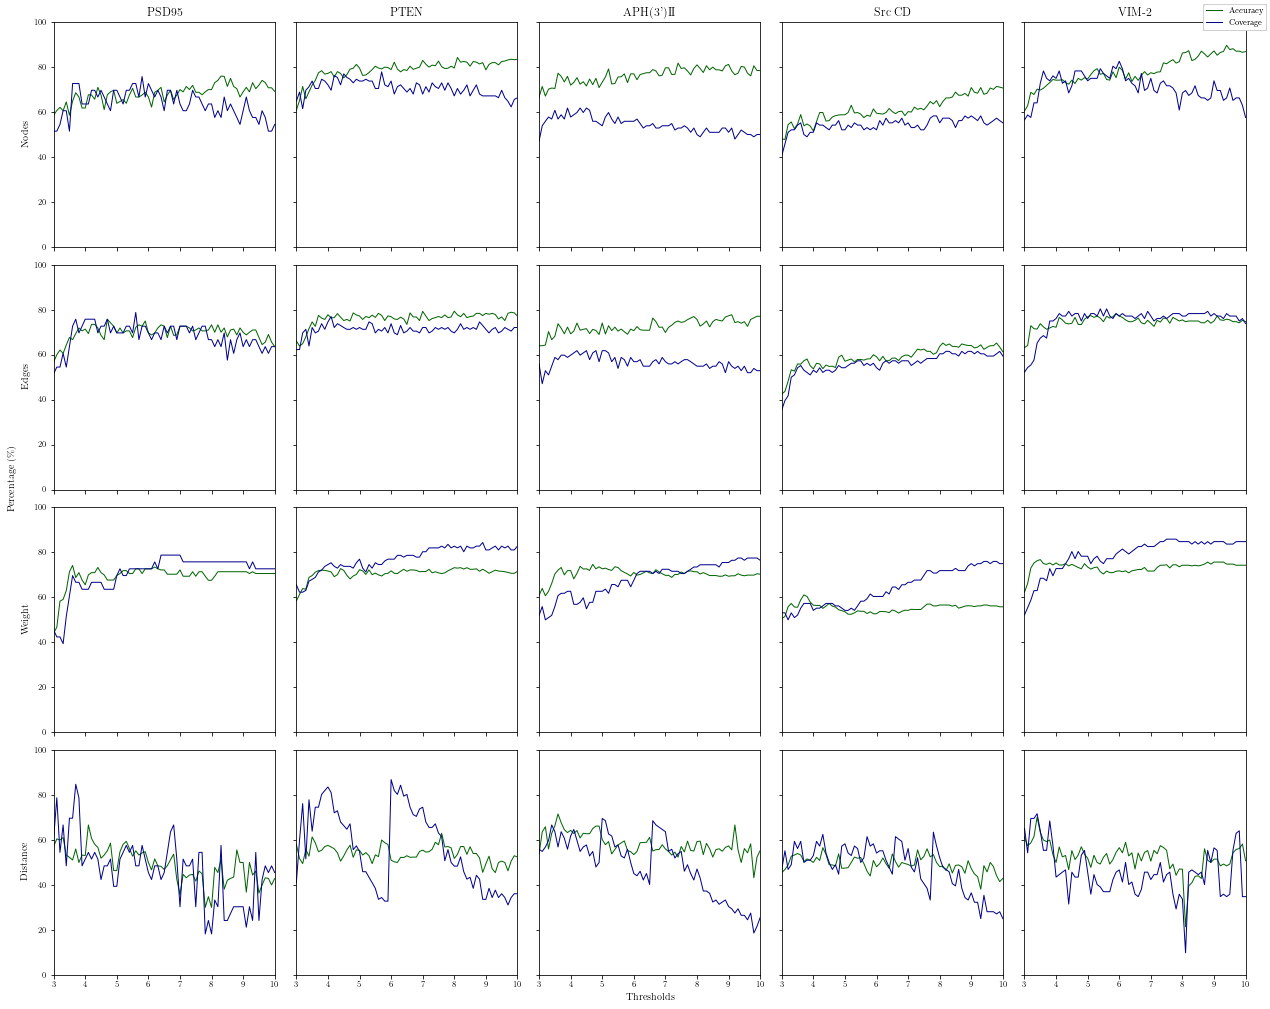

In [112]:
fig = PredictionsOneMeasure(dataOne)
#fig.savefig("figures/one_measure.png", dpi=300)

In [77]:
dfone[dfone.index.get_level_values('Measure').isin(['edges'])].mean()

Max Accuracy    75.3
Max Coverage    71.9
dtype: float64

### Comparing perturbation cutoffs with accuracy and coverage scores

In [17]:
def dataCompare(functional_cutoff, network_mincount, thresh=9.0):
    """Obtain data to compare Accuracy and Coverage scores for range of measure cutoffs, considering same cutoff for 
    four measures, ranging from 1 to 2. Considering loss of function predictions."""
    cutoffs = [x for x in np.linspace(1,2,51)]
    
    index = pd.MultiIndex.from_product([proteins, ["Accuracy", "Coverage"]], names=["Protein", "Measure"])
    df = pd.DataFrame(index=index, columns=cutoffs)
    
    for protein in proteins:
        funct_extremes = GetPercentage(functional_cutoff, 'lowest', functional_data[protein])
        for cutoff in cutoffs:
            measure_cutoffs = [cutoff]*4
            network_extremes = GetNetworkExtremes(protein, network_mincount, measure_cutoffs=measure_cutoffs, 
                                                  thresh=thresh)
            how_many = network_extremes.intersection(funct_extremes)
            df.at[(protein, "Accuracy"), cutoff] = ToPercentage(how_many, network_extremes)
            df.at[(protein, "Coverage"), cutoff] = ToPercentage(how_many, funct_extremes)
           
    return df

In [95]:
def CompareAC(df_list):
    """Compare Accuracy and Coverage scores for range of measure cutoffs, returns plot. Based on df resulting 
    from dataCompare, can take 1 or multiple. Input as list of DataFrames. """
    
    n = len(df_list)
        
    fig, axes = plt.subplots(nrows=n, ncols=5, figsize=(14,(2.8*n)), sharex=True, sharey=True)
    plt.tight_layout()
    
    fig.add_subplot(111, frameon=False)
    plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
    plt.ylabel('Percentage (\%)')
    plt.xlabel('Cutoffs')
    ax = plt.gca()
    ax.xaxis.set_label_coords(0.5, -0.1) if n == 1 else ax.yaxis.set_label_coords(-0.01, 0.5)
    ax.yaxis.set_label_coords(-0.05, 0.5) if n != 1 else ax.yaxis.set_label_coords(-0.03, 0.5)
    
    cutoffs = [x for x in np.linspace(1,2,51)]
    
    for j, df in enumerate(df_list):
        for i, protein in enumerate(proteins):
            accuracy, coverage = [], []
            accuracy = df.loc[(protein, "Accuracy"), :].values.tolist()
            coverage = df.loc[(protein, "Coverage"), :].values.tolist()

            ax = axes[j,i] if n != 1 else axes[i]
            ax.set_xlim(1,2)
            ax.set_ylim(0,100)

            ax.plot(cutoffs, accuracy, color='darkgreen', markeredgewidth=0.0, linewidth=1, label='Accuracy')
            ax.plot(cutoffs, coverage, color='darkblue', markeredgewidth=0.0, linewidth=1, label='Coverage')
            
            #ax.set_aspect(1./ax.get_data_ratio())
            
            if j == 0:
                ax.set_title(protein_names[i])
            if i == 0 and n != 1:
                ax.set_ylabel(f"Min. count = {j+1}")
    
    handles, labels = ax.get_legend_handles_labels()       
    fig.legend(handles, labels)
        
    return fig

In [75]:
compare1 = dataCompare(0.4,1)
compare2 = dataCompare(0.4,2)
compare3 = dataCompare(0.4,3)
compare4 = dataCompare(0.4,4)

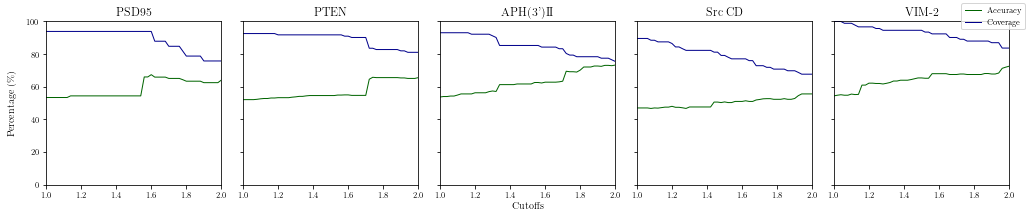

In [91]:
compare1_fig = CompareAC([compare1])
#compare1_fig.savefig("figures/compare_ac_min1.png", dpi=300)

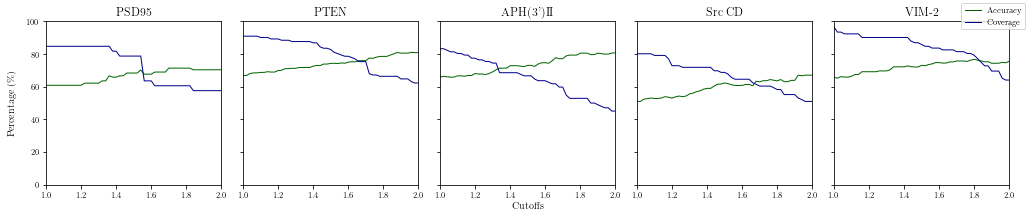

In [92]:
compare2_fig = CompareAC([compare2])
#compare2_fig.savefig("figures/compare_ac.png", dpi=300)

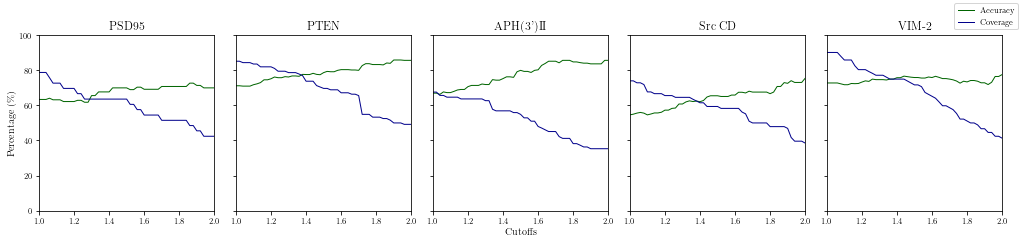

In [48]:
compare3_fig = CompareAC([compare3])
#compare3_fig.savefig("figures/compare_ac_min3.png", dpi=300)

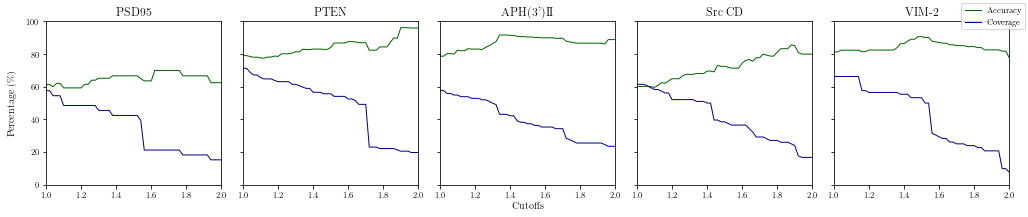

In [93]:
compare4_fig = CompareAC([compare4])
#compare4_fig.savefig("figures/compare_ac_min4.png", dpi=300)

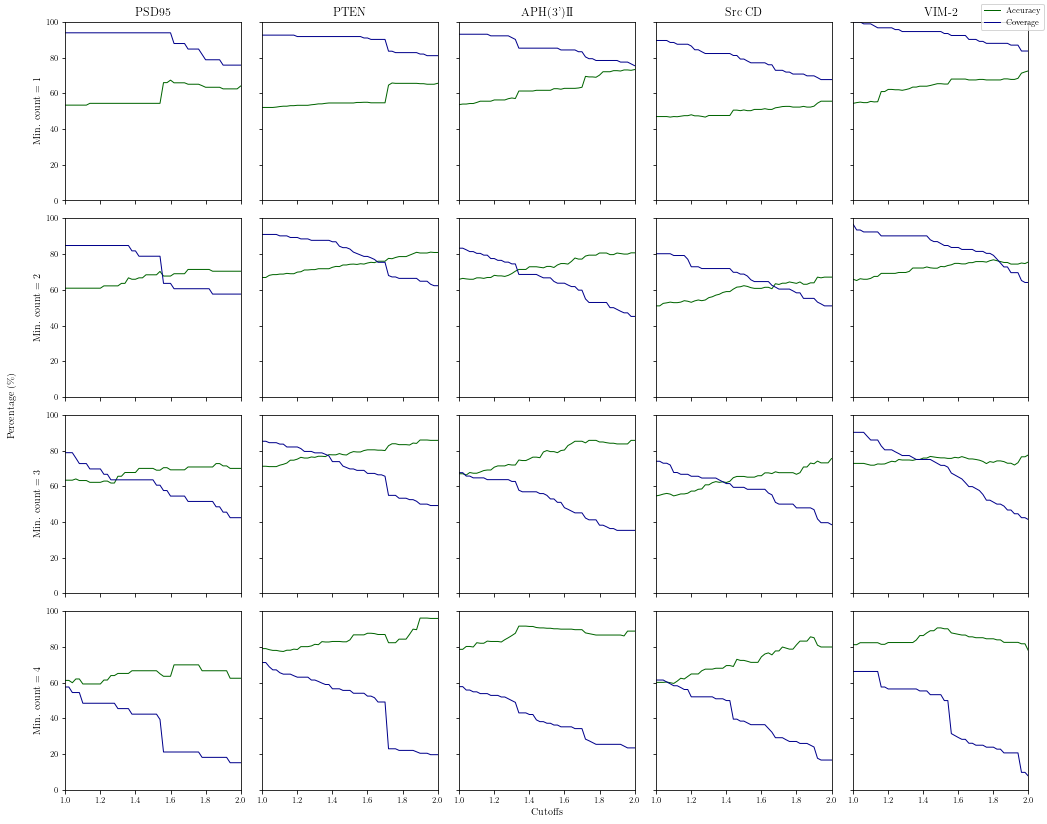

In [230]:
compare_all = CompareAC([compare1, compare2, compare3, compare4])
compare_all.savefig("figures/compare_ac_all.png", dpi=300, bbox_inches='tight')

In [245]:
### Comparing scores across different minimum counts
## mean contains mean over cutoffs, for each protein, measure and min count
index = pd.MultiIndex.from_product([proteins, ["Accuracy", "Coverage"]], names=["Protein", "Measure"])
mean = pd.DataFrame(index=index, columns=[1,2,3,4])

for i,data in enumerate([compare1, compare2, compare3, compare4]):
    mean[i+1] = data.mean(axis=1)

In [246]:
mean

1          2          3          4
Protein Measure                                             
1be9    Accuracy  58.774510  66.596078  67.715686  64.850980
        Coverage  88.868627  72.592157  59.760784  34.586275
1d5r    Accuracy  57.249020  74.154902  78.790196  84.480392
        Coverage  88.988235  79.523529  68.970588  48.286275
1nd4    Accuracy  62.707843  73.441176  77.550980  86.927451
        Coverage  85.425490  65.374510  52.037255  39.482353
3dqw    Accuracy  50.113725  59.460784  64.082353  71.945098
        Coverage  78.696078  66.956863  57.945098  40.386275
4bz3    Accuracy  64.272549  72.231373  74.417647  84.386275
        Coverage  92.754902  84.158824  67.858824  42.284314

In [248]:
## Mean accuracy for each min count
mean[mean.index.get_level_values("Measure").isin(['Accuracy'])].mean()

1    58.623529
2    69.176863
3    72.511373
4    78.518039
dtype: float64

In [249]:
## Mean coverage for each min count
mean[mean.index.get_level_values("Measure").isin(['Coverage'])].mean()

1    86.946667
2    73.721176
3    61.314510
4    41.005098
dtype: float64

In [267]:
compare4[compare4.index.get_level_values("Measure").isin(["Coverage"])]

,,1.00,1.02,1.04,1.06,1.08,1.10,1.12,1.14,1.16,1.18,1.20,1.22,1.24,1.26,1.28,1.30,1.32,1.34,1.36,1.38,1.40,1.42,1.44,1.46,1.48,1.50,1.52,1.54,1.56,1.58,1.60,1.62,1.64,1.66,1.68,1.70,1.72,1.74,1.76,1.78,1.80,1.82,1.84,1.86,1.88,1.90,1.92,1.94,1.96,1.98,2.00
Protein,Measure,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1be9,Coverage,57.6,57.6,54.5,54.5,54.5,48.5,48.5,48.5,48.5,48.5,48.5,48.5,48.5,48.5,48.5,45.5,45.5,45.5,45.5,42.4,42.4,42.4,42.4,42.4,42.4,42.4,42.4,39.4,21.2,21.2,21.2,21.2,21.2,21.2,21.2,21.2,21.2,21.2,21.2,18.2,18.2,18.2,18.2,18.2,18.2,18.2,18.2,15.2,15.2,15.2,15.2
1d5r,Coverage,71.3,71.3,68.9,67.2,67.2,65.6,64.8,64.8,64.8,63.9,63.1,63.1,63.1,63.1,61.5,61.5,60.7,59.8,59,59,56.6,56.6,56.6,55.7,55.7,55.7,54.1,54.1,54.1,54.1,52.5,52.5,51.6,49.2,49.2,49.2,23,23,23,22.1,22.1,22.1,22.1,22.1,21.3,20.5,20.5,20.5,19.7,19.7,19.7
1nd4,Coverage,57.8,57.8,55.9,55.9,54.9,54.9,53.9,53.9,53.9,52.9,52.9,52.9,52,52,51,50,49,43.1,43.1,43.1,42.2,42.2,39.2,38.2,38.2,37.3,37.3,36.3,36.3,35.3,35.3,35.3,35.3,34.3,34.3,34.3,28.4,27.5,26.5,25.5,25.5,25.5,25.5,25.5,25.5,25.5,25.5,24.5,23.5,23.5,23.5
3dqw,Coverage,61.5,61.5,61.5,60.4,59.4,58.3,58.3,57.3,56.2,56.2,52.1,52.1,52.1,52.1,52.1,52.1,52.1,51,51,51,50,50,39.6,39.6,38.5,38.5,37.5,36.5,36.5,36.5,36.5,36.5,34.4,32.3,29.2,29.2,29.2,28.1,27.1,27.1,27.1,26,26,26,25,24,17.7,16.7,16.7,16.7,16.7
4bz3,Coverage,66.3,66.3,66.3,66.3,66.3,66.3,66.3,66.3,57.6,57.6,56.5,56.5,56.5,56.5,56.5,56.5,56.5,56.5,56.5,55.4,55.4,55.4,53.3,53.3,53.3,53.3,50,50,31.5,30.4,29.3,28.3,28.3,26.1,26.1,25,25,25,23.9,23.9,23.9,22.8,22.8,20.7,20.7,20.7,20.7,20.7,9.8,9.8,7.6


In [ ]:
1.5, 1.7, 1.7, 1.4, 1.55